# Understat Series : Top 2 Goalscorers


**By Jose Gonzalez**
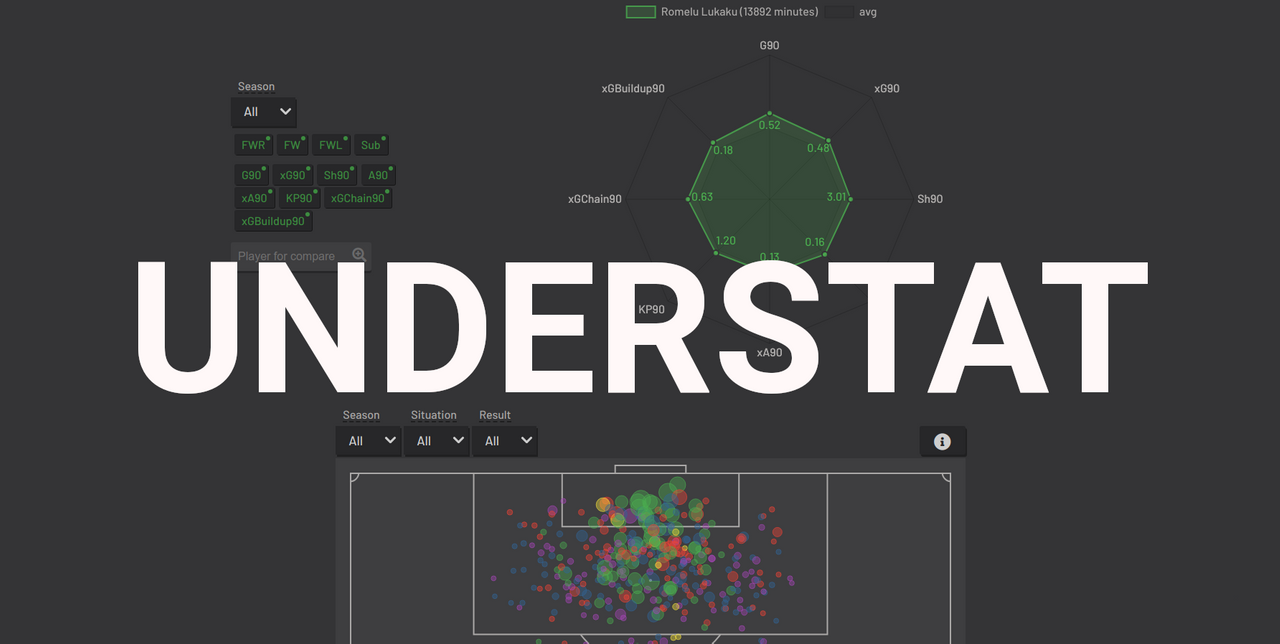


<a id="1."></a>
# Introduction
Inspired by this [tweet](https://twitter.com/jonollington/status/1369689519872675843) by Jon Ollington , I've decided I will try to replicate by scraping , cleaning and then plotting from Understat.

<a id="1.1"></a>
# Notebook content
* [1. Introduction](#1.)
    - [1.1. Notebook Content.](#1.1)
* [2. Importing libraries.](#2.)
* [3. Scraping La Liga player stats.](#3.)
    - [3.1. Groupby teams and goals.](#3.1)
* [4. Plotting top 2 Goalscorers](#4.)
   -  [4.1. Divergin bars.](#4.1)
   -  [4.2. Diverging bars with text](#4.2)


<a id="2."></a>
# Importing Libraries

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib.patches import Arc
import numpy as np
from highlight_text import fig_text
import seaborn as sns
import requests
from bs4 import BeautifulSoup

<a id="3."></a>
# Scraping La Liga player stats
Let's start by scraping the statistics from La Liga players , xG, Goals, assists etc. Then we proceed by filtering so we won't have as many columns.

In [16]:
# Entering the league's  link
link = "https://understat.com/league/La_liga"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')
# Get the table 
strings = scripts[3].string 
# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)

# Creating a dataframe
df = pd.DataFrame(data)

# Filtering the data 
df = df[['player_name','team_title','goals','assists','xG','xA']]
df = df.astype({"xG": float, "goals": int, "assists": int, "xA": float, "team_title": str,'player_name':str})


<a id="3.1"></a>
## Groupby team and goals
Now let's group the dataframe by teams and then using the function nlargest we'll obtain the 2 best goalscorers in each team :

In [17]:
# Getting the 2 best goalscorers 
df = df.set_index('player_name').groupby('team_title')['goals'].nlargest(2).reset_index()

In [19]:
df.head(5)

,team_title,player_name,goals
0,Alaves,Joselu,11
1,Alaves,Edgar Méndez,5
2,"Alaves,Athletic Club",Iñigo Córdoba,0
3,"Alaves,Granada",Adrián Marín,0
4,Athletic Club,Alex Berenguer,8


Ooops , here is a problem, some players have played for 2 different teams in La liga as you can see with Iñigo Córdoba and Adrián Marín , We cannot have that ,so in order to eliminate let's get rid of every row containing the"," character,  because as you can see, that's how the players that played for different teams are represented : 

<a id="3.2"></a>
## Eliminating duplicates

In [20]:
# Eliminating player duplicates
df = df[~df.team_title.str.contains(",")]

And now we do not have more duplicates, players that played for several teams.

In [23]:
df

,team_title,player_name,goals
11,Barcelona,Lionel Messi,30
50,Villarreal,Gerard Moreno,23
37,Real Madrid,Karim Benzema,23
7,Atletico Madrid,Luis Suárez,21
46,Sevilla,Youssef En-Nesyri,18
39,Real Sociedad,Alexander Isak,16
31,Levante,Morales,14
17,Celta Vigo,Iago Aspas,14
44,SD Huesca,Rafa Mir,13
12,Barcelona,Antoine Griezmann,13


Now let's sort the dataframe by the team name and by the number of goals scored :

In [22]:
# sorting the dataframe 
df = df.sort_values(['goals','team_title'],ascending=False)


In order to represent the 2 best goalscorers we must separate them in 2 different dataframes ,  the best goalscorers for example Messi and the second best goalscorers, in this case Griezmann.

There is also an issue of length for the names of the teams, They must be shorten up to only 3 letters to fit the the plot, and here we run into another problem is that several teams start with the same name such as **Real** Betis, **Real** Madrid, **Real** Sociedad , therefore We cannot have 4 different teams with REA as their shorten names, so we must replace their names with the name of the city rather than their first name , such as Madrid instead of Real Madrid, Sociedad instead of Real Sociedad :  

In [36]:
#New column for bool value
df['bool'] = df['team_title'].duplicated(keep='first')

# cleaning the title names 
df['team_title'] = df['team_title'].str.replace('Real Madrid','Madrid')
df['team_title'] = df['team_title'].str.replace('Real Sociedad','Sociedad')
df['team_title'] = df['team_title'].str.replace('Real Betis','Betis')

# Creating new columns for shortening team names
df['names'] = df['team_title'].str[0:3]

# Capital letters for team names
df['names'] = df['names'].str.upper()

Now let's sort the dataframe by the goals scored : 

In [25]:
# Sorting values
df = df.sort_values(['names'],ascending=True)
# Dividing the DataFrames in highest goalscorer and second highest goalscorer
df_min = df[df['bool']==True] # Highest
df_max = df[df['bool']==False] # Second Highest


<a id="4."></a>
# Plotting Top 2 Goalscorers 
Now let's go ahead and plot the top 2 goalscorers and also add the names of the players : 

<a id="4.1"></a>
## Part I

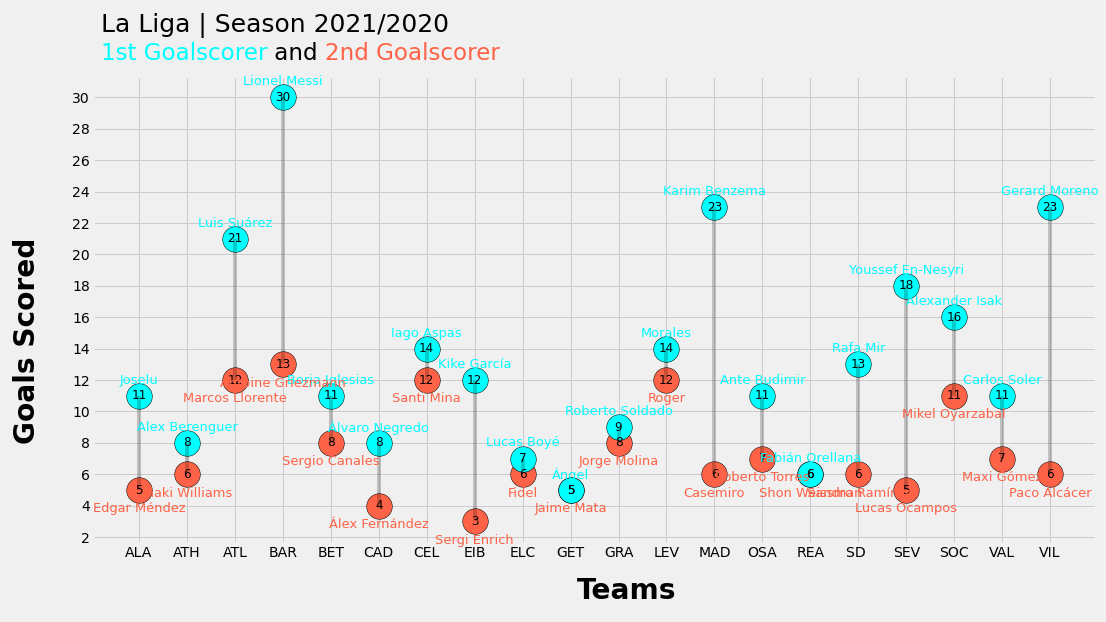

In [33]:
# plot style 
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots(figsize = (16,8))

# plotting
ax.scatter(df_min['names'],df_min['goals'], color='tomato', edgecolor='black',s=655, label="Second Best Scorer")
ax.scatter(df_max['names'],df_max['goals'], color='cyan', edgecolor='black',s=655, label="First Best Scorer")

# title
fig_text(0.08,0.94, s=" <1st Goalscorer> and <2nd Goalscorer>",highlight_textprops=[{"color":'cyan'}, {'color':"tomato"}], fontsize = 23, fontweight="light", color = "black")
fig_text(0.08,0.99, s=" La Liga | Season 2021/2020 ", fontsize = 25, fontweight="light")

# text
fig_text(0.5,0.01, s="Teams\n", fontsize = 28, fontweight = "bold", color = "black")
fig_text(0.01,0.6, s="Goals Scored\n", fontsize = 28, fontweight = "bold", color = "black",rotation=90)
plt.yticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30])


# Horizontal lines
plt.vlines( ymin=df_min['goals'], ymax=df_max['goals'],x=df_max['names'], color='black', alpha=0.2,linestyle="solid")

# Annotate text goals
for i in range(len(df_min['goals'].tolist())):
    plt.annotate(df_min['goals'].tolist()[i], (df_min['names'].tolist()[i],df_min['goals'].tolist()[i]),c='black',size=12,ha='center',va='center')
for i in range(len(df_max['goals'].tolist())):
    plt.annotate(df_max['goals'].tolist()[i], (df_max['names'].tolist()[i],df_max['goals'].tolist()[i]),c='black',size=12,ha='center',va='center')    

# Annotate text player names
for i in range(len(df_max['goals'].tolist())):
    plt.annotate(df_max['player_name'].tolist()[i], (df_max['names'].tolist()[i],df_max['goals'].tolist()[i]+1),c='cyan',size=13,ha='center',va='center')  
for i in range(len(df_min['goals'].tolist())):
    plt.annotate(df_min['player_name'].tolist()[i], (df_min['names'].tolist()[i],df_min['goals'].tolist()[i]-1.2),c='tomato',size=13,ha='center',va='center')  


It does seem a bit too loaded so now let's try it without the names

<a id="4.2"></a>
## Part II

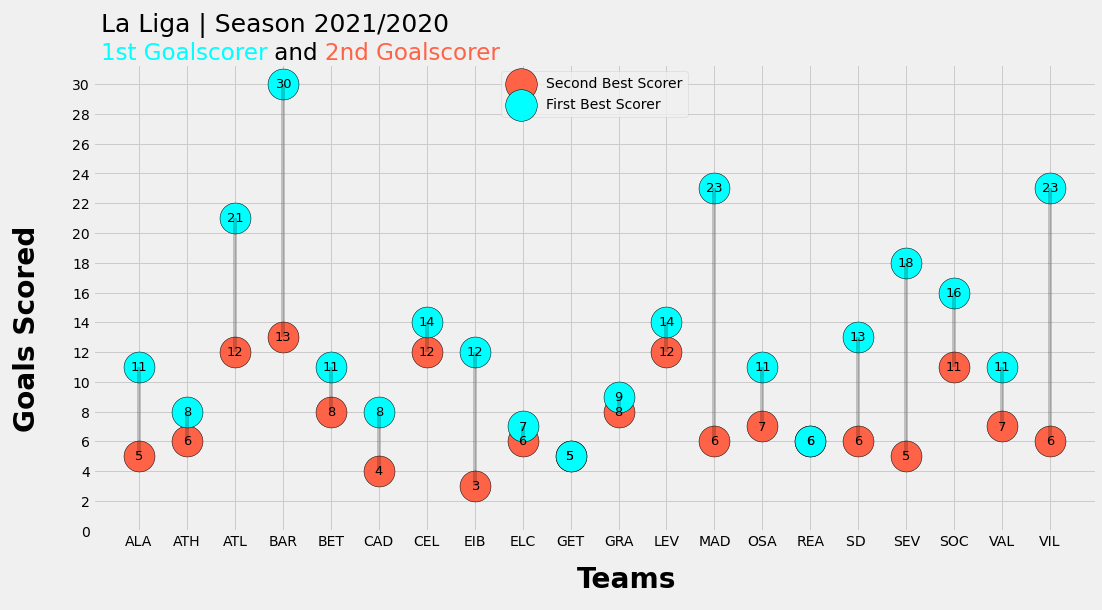

In [34]:
# plot style 
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots(figsize = (16,8))

# plotting
ax.scatter(df_min['names'],df_min['goals'], color='tomato', edgecolor='black',s=955, label="Second Best Scorer")
ax.scatter(df_max['names'],df_max['goals'], color='cyan', edgecolor='black',s=955, label="First Best Scorer")

# Horizontal lines
plt.vlines( ymin=df_min['goals'], ymax=df_max['goals'],x=df_max['names'], color='black', alpha=0.2,linestyle="solid")

# title
fig_text(0.08,0.92, s=" <1st Goalscorer> and <2nd Goalscorer>",highlight_textprops=[{"color":'cyan'}, {'color':"tomato"}], fontsize = 23, fontweight="light", color = "black")
fig_text(0.08,0.97, s=" La Liga | Season 2021/2020 ", fontsize = 25, fontweight="light")

# text
fig_text(0.5,0.01, s="Teams\n", fontsize = 28, fontweight = "bold", color = "black")
fig_text(0.01,0.6, s="Goals Scored\n", fontsize = 28, fontweight = "bold", color = "black",rotation=90)
plt.yticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30])

# Annotate text goals
for i in range(len(df_min['goals'].tolist())):
    plt.annotate(df_min['goals'].tolist()[i], (df_min['names'].tolist()[i],df_min['goals'].tolist()[i]),c='black',size=13,ha='center',va='center')
for i in range(len(df_max['goals'].tolist())):
    plt.annotate(df_max['goals'].tolist()[i], (df_max['names'].tolist()[i],df_max['goals'].tolist()[i]),c='black',size=13,ha='center',va='center')    

    # legend
legend = ax.legend(loc="upper center")
legend.legendHandles[0]._sizes = [1000]
legend.legendHandles[1]._sizes = [1000]